<h1>
<center>Navid Bahadoran</center>
</h1>
<h1>
<center>Homework 9, due November 10th, 11:59pm</center>
</h1>

<h2>
<center>Nov 2, 2023</center>
</h2>
In this homework, you are required to include in your report the code that you
implemented. If you use some code from the web or package, also mention in your
report the origin of the code.<br>
1. Load the image scene256.jpg from Canvas as a $164\times256\times3$ array. Normalize
the image by dividing it by 256. We will cluster the $164 \times 256 = 41984$ pixels using
spectral clustering.<br>
Construct an affinity matrix A between the pixels, with
$$A(i, j) = exp(−\lVert I(i) − I(j)\rVert^{2}/\sigma^{2})$$
if pixels i and j are neighbors (left, right, top or down), otherwise zero. Here $I(i) =
(R(i),G(i),B(i))$ is the RGB triplet of values of pixel i of the image I and a value of
$\sigma= 0.03$ works fine.<br>
Implement the spectral clustering algorithm discussed in the Clustering section using
the affinity matrix A.<br>
Use sparse matrices and sparse SVD (e.g. scipy.sparse.linalg.svds) for speed.

In [1]:
# remove warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

Logic behind the Affinity matrix function:

1)It accepts two parameters: image, which is the input image, and sigma, which is a parameter used to control the scale of the affinity computation.

2)It extracts the height, width, and the number of pixels in the input image.

3)It initializes an empty sparse matrix A using the Compressed Sparse Row (CSR) format to store the pairwise affinities between pixels. The matrix's shape is (num_pixels, num_pixels).

4)It iterates through each pixel in the image using two nested loops (i and j) to cover all pixels.

5)For each pixel, it calculates the RGB triplet of values and stores it in pixel_i. This represents the color of the current pixel.

6)It then checks the neighboring pixels in the top, bottom, left, and right directions using another loop. If the neighbor is within the image boundaries (0 <= x < height and 0 <= y < width), it calculates the RGB value of the neighbor pixel and stores it in pixel_j.

7)Next, it calculates the Euclidean distance between pixel_i and pixel_j. This distance measure quantifies the similarity or dissimilarity between the colors of two pixels.

8)Using the calculated distance, it computes the affinity between the two pixels using a Gaussian kernel function with the formula: affinity = exp(-distance**2 / (sigma**2)). This function assigns a higher affinity to neighboring pixels with similar colors and a lower affinity to pixels with dissimilar colors.

9)Finally, it sets the computed affinity in the A matrix at the corresponding positions for the current pixel and its neighbor, essentially building the affinity matrix.

The resulting A matrix is a sparse matrix that represents the pairwise affinities between pixels in the image. This affinity matrix is then used for spectral clustering to group pixels with similar colors into clusters.

In [2]:
import numpy as np
from scipy import sparse
from skimage import io
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import torch
from IPython.display import display, Markdown, display_markdown

# Determine the device
my_device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"The calculation was done using {my_device}")

# Load the image and normalize it
image = io.imread(r'D:\Pycharm\Courses\STA5635\HW9\scene256.jpg') / 256.0
height, width, _ = image.shape
image_flat = image.reshape(-1, 3)
# Define the parameters
sigma = 0.03

# Extract RGB channels
R, G, B = image[:, :, 0], image[:, :, 1], image[:, :, 2]

# Calculate the affinity matrix A
def affinity_matrix(image, sigma):
    height, width, _ = image.shape
    num_pixels = height * width

    # Create an empty sparse matrix
    A = sparse.lil_matrix((num_pixels, num_pixels))

    for i in range(height):
        for j in range(width):
            # Compute the pixel's RGB value
            pixel_i = np.array((R[i, j], G[i, j], B[i, j]))

            for x, y in [(i - 1, j), (i, j - 1), (i + 1, j), (i, j + 1)]:
                if 0 <= x < height and 0 <= y < width:
                    # Compute the RGB value of the neighbor pixel
                    pixel_j = np.array((R[x, y], G[x, y], B[x, y]))

                    # Calculate the Euclidean distance between pixel_i and pixel_j
                    distance = np.linalg.norm(pixel_i- pixel_j)

                    # Calculate the affinity and set it in the matrix
                    affinity = np.exp(-(distance**2) / (sigma**2))
                    A[i * width + j, x * width + y] = affinity

    return A

A = affinity_matrix(image, sigma).tocsr()
D = np.asarray(A.sum(axis=1)).flatten()
d_sqrt = sparse.diags(1./np.sqrt(D)).tocsr()
L = d_sqrt @ A @ d_sqrt
L_tensor = torch.sparse_csr_tensor(torch.LongTensor(L.indptr),
                                    torch.LongTensor(L.indices),
                                    torch.FloatTensor(L.data),
                                    device = my_device)

The calculation was done using cpu


**a) Display the obtained clustering with 10 clusters as an 164 × 256 label image. (4
points)<br>
b) Construct a 164×256 color image where for each cluster you compute the means
of the R, G, and B values of the pixels of that cluster and place that mean at all
locations of the pixels from this cluster. (2 points)**

In [3]:
def spectral_clustering(Laplac_Mat,n_clusters):
    
    eig_value, eig_vec = torch.lobpcg(Laplac_Mat, k=n_clusters, largest = True)
    # Normalize each row/column
    eig_vec = torch.nn.functional.normalize(eig_vec, dim=1)

    # Do k-means
    km = KMeans(n_clusters=n_clusters, n_init='auto')
    km.fit(eig_vec.detach().cpu().numpy())

    # Construct label image
    label_image = km.labels_.reshape(height, width)


    display_markdown(f'{n_clusters} clusters as an 164 × 256 label image', raw=True)
    # Display the label image and the original image
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(label_image)
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.show()

    # Part (b)
    flat_mean_image = np.zeros((width*height, 3))

    # Loop over all clusters
    for label in np.unique(km.labels_):
        indx = np.where(km.labels_ == label)
        flat_mean_image[indx] = np.mean(image_flat[indx], axis=0)

    display_markdown(f'{n_clusters} clusters mean image', raw=True)
    # Display the mean color image
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(flat_mean_image.reshape(height, width, 3))
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.show()

10 clusters as an 164 × 256 label image

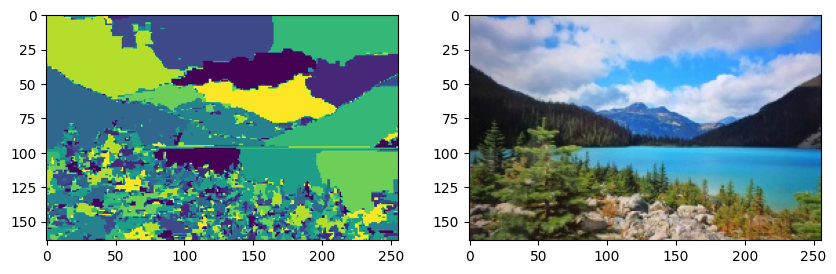

10 clusters mean image

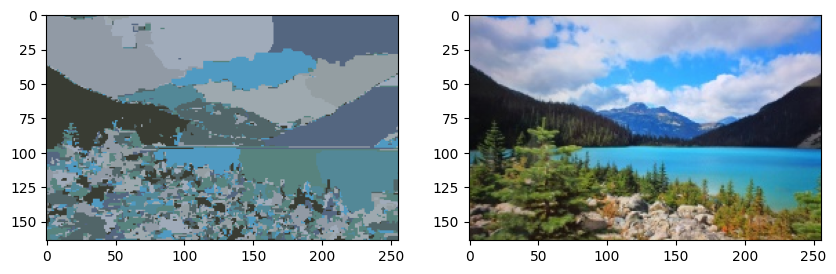

In [4]:
spectral_clustering(L_tensor,10)

**c) Repeat points a) and b) with 20 clusters. (3 points)**

20 clusters as an 164 × 256 label image

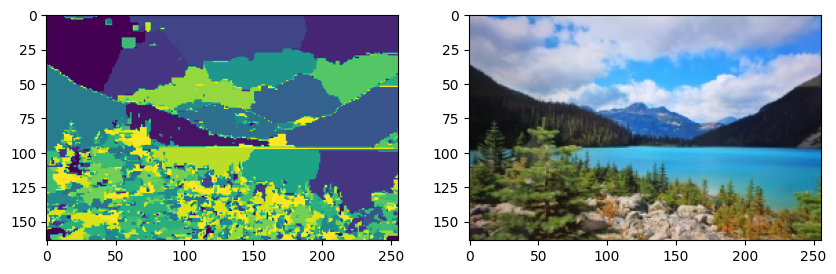

20 clusters mean image

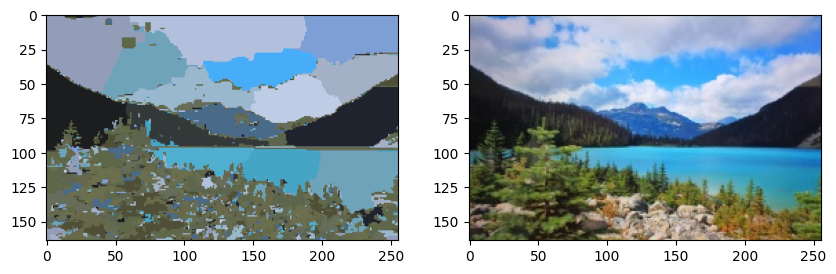

In [7]:
spectral_clustering(L_tensor,20)

This is just for the test. With 100 Cluster

100 clusters as an 164 × 256 label image

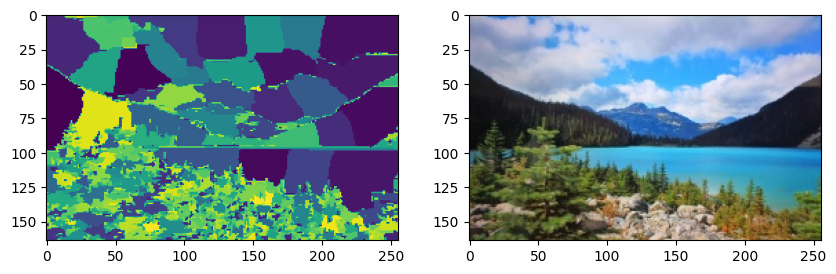

100 clusters mean image

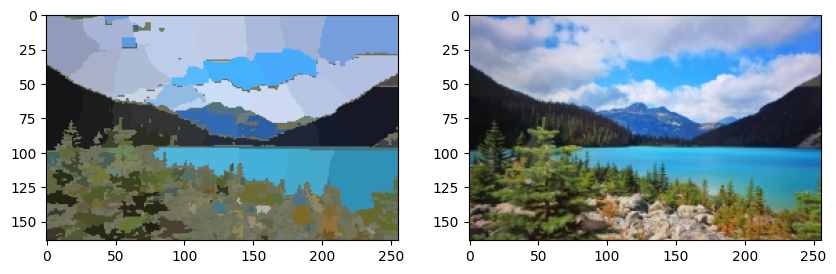

In [6]:
spectral_clustering(L_tensor,100)